### Inpainting

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from nnf import NNF

In [11]:
class InpaintNNF:
    """
    Class for inpainting an image using the PatchMatch algorithm.
    Follows downsample-then-upsample approach.
    """
    def __init__(self, image, mask, patch_w=7, max_pm_iters=5):
        """
        image: numpy array of shape (height, width, 3)
        mask: numpy array of shape (height, width)
        """
        # ensure size of image and mask are the same
        assert image.shape[1] == mask.shape[1] and image.shape[0] == mask.shape[0]
        self.image = image
        self.mask = mask
        self.patch_w = patch_w
        self.max_pm_iters = max_pm_iters
        self.pyramid = [] # list to store the downsampled images and masks
        
        self._build_pyramid()
        
    
    def _build_pyramid(self):
        """
        Build the image pyramid.
        """
        self.pyramid.append((self.image, self.mask))
        img = self.image.copy()
        mask = self.mask.copy()
        while img.shape[0] > 2*self.patch_w and img.shape[1] > 2*self.patch_w:
            img = self._downsample_img(img, 2)
            mask = self._downsample_mask(mask, 2)
            self.pyramid.append((img, mask))
        
        
    def _downsample_img(self, img, factor):
        return cv2.resize(img, (img.shape[1]//factor, img.shape[0]//factor))
    
    def _upsample_img(self, img, src_size):
        height, width, _ = src_size
        return cv2.resize(img, (width, height))
    
    def _downsample_mask(self, mask, factor):
        mask = cv2.resize(mask, (mask.shape[1]//factor, mask.shape[0]//factor))
        mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
        return mask
        
    
    def expectation_maximization(self, src, target, nnf_src_to_target_obj, nnf_target_to_src_obj):
        """
        src: numpy array of shape (height, width, 3)
        target: numpy array of shape (height, width, 3)
        """
        # compute the nnfs
        nnf_src_to_target, nnf_src_to_target_dist = nnf_src_to_target_obj.compute_nnf()
        nnf_target_to_src, nnf_target_to_src_dist = nnf_target_to_src_obj.compute_nnf()
        
        # reconstruct source image
        reconstructed_src = np.zeros_like(src, dtype=np.float32)
        count_src = np.zeros_like(src, dtype=np.float32)
        
        for ay in range(src.shape[0] - self.patch_w + 1):
            for ax in range(src.shape[1] - self.patch_w + 1):
                bx, by = nnf_src_to_target[ay, ax]
                
                reconstructed_src[ay:ay + self.patch_w, ax:ax + self.patch_w] += target[by:by + self.patch_w, bx:bx + self.patch_w]
                count_src[ay:ay + self.patch_w, ax:ax + self.patch_w] += 1
                
        reconstructed_src /= count_src
        
        # reconstruct target image
        reconstructed_target = np.zeros_like(target, dtype=np.float32)
        count_target = np.zeros_like(target, dtype=np.float32)
        
        for ay in range(target.shape[0] - self.patch_w + 1):
            for ax in range(target.shape[1] - self.patch_w + 1):
                bx, by = nnf_target_to_src[ay, ax]
                
                reconstructed_target[ay:ay + self.patch_w, ax:ax + self.patch_w] += src[by:by + self.patch_w, bx:bx + self.patch_w]
                count_target[ay:ay + self.patch_w, ax:ax + self.patch_w] += 1
                
        reconstructed_target /= count_target
        
        # merge the two reconstructed images
        # print(src.shape, target.shape, reconstructed_src.shape, reconstructed_target.shape)
        reconstructed_img = np.zeros_like(src, dtype=np.float32)
        reconstructed_img = (reconstructed_src + reconstructed_target) / 2
        reconstructed_img = reconstructed_img.astype(np.uint8)
        
        # return the reconstructed image and return the nnfs
        return reconstructed_img, nnf_src_to_target, nnf_target_to_src
        
    def inpaint(self):
        num_pyramid_levels = len(self.pyramid)
        inpainted_img = None
        running_nnf_src_to_target = None
        running_nnf_target_to_src = None
        for level in range(num_pyramid_levels-1, -1, -1):
            print("Level: ", level)
            iterEM = 1+2*level;
            iterNNF = min(7,1+level)
            src, mask = self.pyramid[level]
            src_with_mask = src.copy() * np.stack([mask]*3, axis=2)
            
            # smallest level
            if level == num_pyramid_levels-1:
                inpainted_img = src.copy()
                
                # initialize the nnfs with masks for both directions
                nnf_src_to_target_obj = NNF(src_with_mask, inpainted_img, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_src_to_target_obj.initialize_nnf_with_mask(mask)
            
                nnf_target_to_src_obj = NNF(inpainted_img, src_with_mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_target_to_src_obj.initialize_nnf_with_mask(mask)
            else:
                # initialize the nnfs with masks for both directions
                nnf_src_to_target_obj = NNF(src_with_mask, inpainted_img, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_src_to_target_obj.initialize_nnf_with_other_nnf(running_nnf_src_to_target)
                nnf_src_to_target_obj.initialize_nnf_with_mask(mask)
            
                nnf_target_to_src_obj = NNF(inpainted_img, src_with_mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_target_to_src_obj.initialize_nnf_with_other_nnf(running_nnf_target_to_src)
                nnf_target_to_src_obj.initialize_nnf_with_mask(mask)
            
            # run the EM algorithm multiple times
            for em_step in range(iterEM):
                inpainted_img, running_nnf_src_to_target, running_nnf_target_to_src = self.expectation_maximization(src, inpainted_img, nnf_src_to_target_obj, nnf_target_to_src_obj)
                nnf_src_to_target_obj.b = inpainted_img.copy()
                nnf_target_to_src_obj.a = inpainted_img.copy()       
                nnf_src_to_target_obj._set_height_width()
                nnf_target_to_src_obj._set_height_width()
            
            # upsample the inpainted image if not the last level
            if level > 0:
                # print(f"inpainted_img shape: {inpainted_img.shape}")
                # print(f"running_nnf_src_to_target shape: {running_nnf_src_to_target.shape}")
                # print(f"running_nnf_target_to_src shape: {running_nnf_target_to_src.shape}")
                inpainted_img = self._upsample_img(inpainted_img, self.pyramid[level-1][0].shape)    
                # print(f"inpainted_img shape after upsample: {inpainted_img.shape}")
                # running_nnf_src_to_target = self._upsample_nnf(running_nnf_src_to_target, 2)
                # running_nnf_target_to_src = self._upsample_nnf(running_nnf_target_to_src, 2)
            # return inpainted_img
            
        return inpainted_img  
                
        

In [12]:
src_img = cv2.imread("../images/football_sky.jpg")
mask = cv2.imread("../images/football_sky_mask.jpg", cv2.IMREAD_GRAYSCALE)
mask = np.where(mask > 127, 1, 0).astype(np.uint8)

In [13]:
inpainter = InpaintNNF(src_img, mask, patch_w=7, max_pm_iters=5)
inpainted_img = inpainter.inpaint()

Level:  5
Level:  4
Level:  3
Level:  2
Level:  1
Level:  0


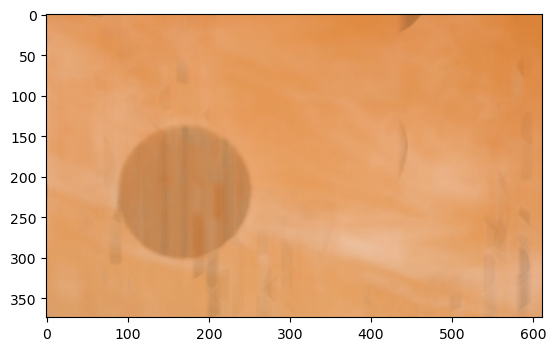

In [14]:
plt.imshow(inpainted_img)

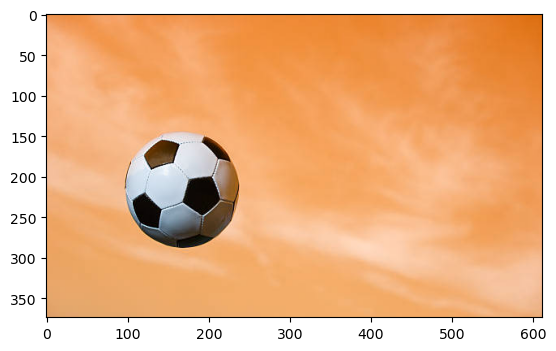

In [17]:
plt.imshow(inpainter.pyramid[0][0])